In [2]:
import cv2
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
import tensorflow as tf
import keras
from tensorflow.keras.layers import Flatten


In [3]:
training_file = 'train.p'
testing_file = 'test.p'

train = pickle.load(open(training_file, "rb"))
test = pickle.load(open(testing_file, "rb"))

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train).union(set(y_test)))

print ("Number of training examples = {}".format(n_train))
print ("Number of testing examples = {}".format(n_test))
print ("Image data shape = {}".format(image_shape))
print ("Number of classes = {}".format(n_classes))

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
# Data exploration visualization
import matplotlib.pyplot as plt
%matplotlib inline

def class_distribution(y, title):
    n_classes = len(set(y))
    class_count = [0] * n_classes
    for n in y:
        class_count[n] += 1
    class_count_index = [0] * n_classes
    for i in range(n_classes):
        class_count_index[i] = i
    plt.figure(figsize=(12,4))
    plt.bar(range(len(class_count)), class_count)
    plt.xticks(range(len(class_count)), class_count_index)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

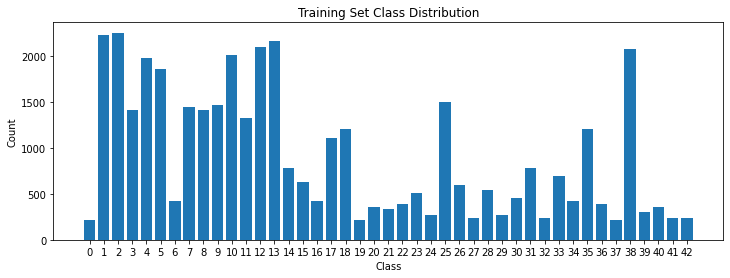

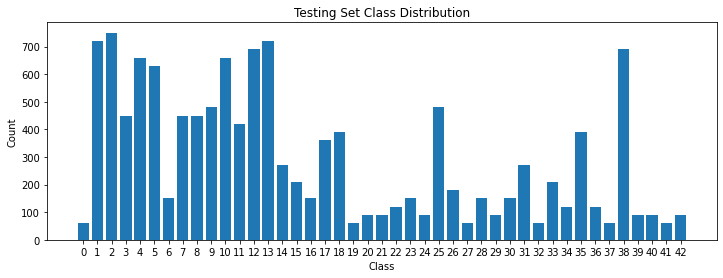

In [6]:
# Compare class distributions of training and test sets
class_distribution(y_train, 'Training Set Class Distribution')
class_distribution(y_test, 'Testing Set Class Distribution')

In [7]:
# plot RGB or grayscale images
def plot_images(X, y, image_indices, grayscale=False, title=None):
    for i in range(len(image_indices)):
        plt.figure()
        if title is None:
            plt.title("Class " + str(y[image_indices[i]]))
        else:
            plt.title(title)
        if not grayscale:
            plt.imshow(X[image_indices[i]])
        else:
            plt.imshow(X[image_indices[i]], cmap='gray')

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


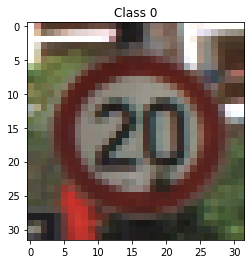

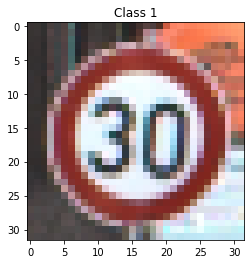

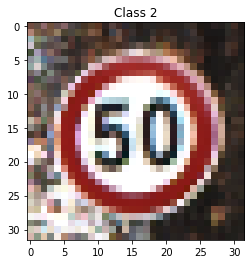

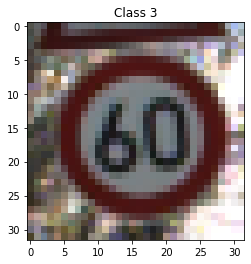

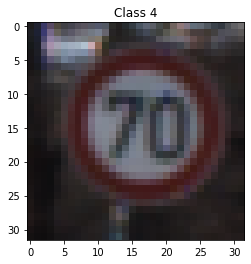

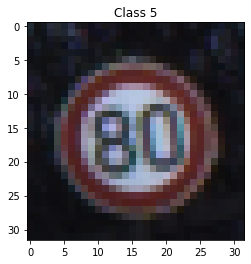

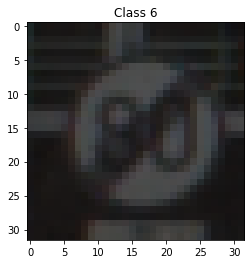

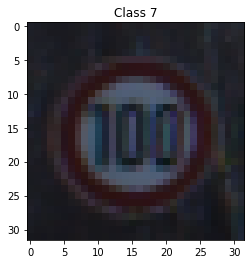

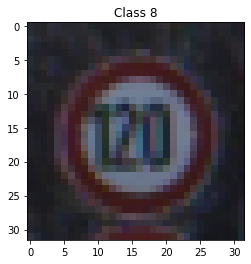

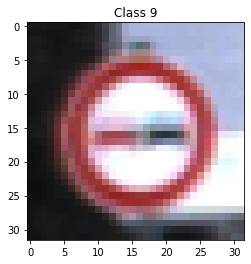

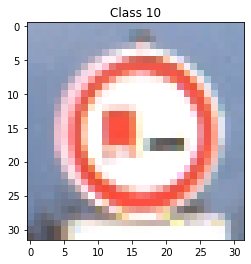

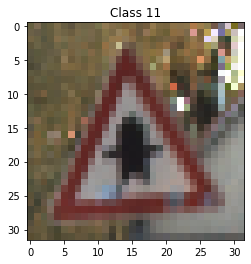

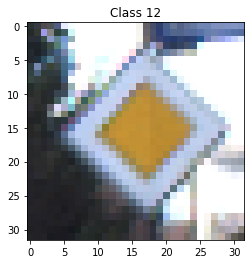

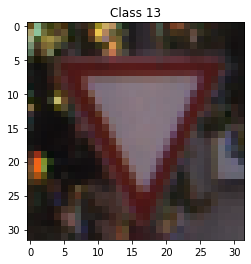

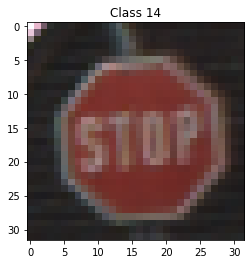

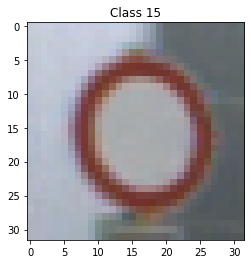

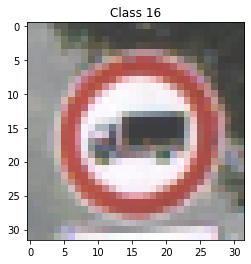

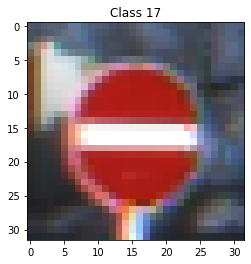

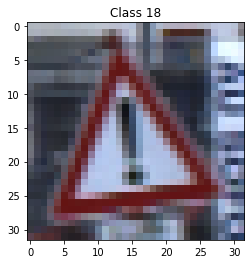

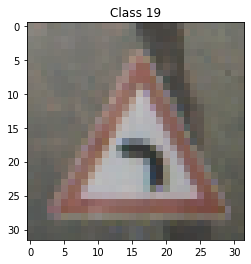

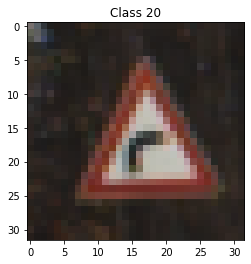

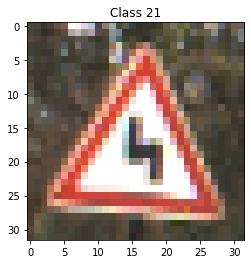

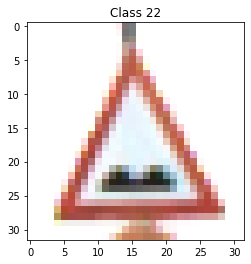

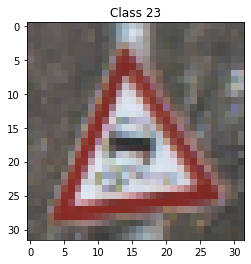

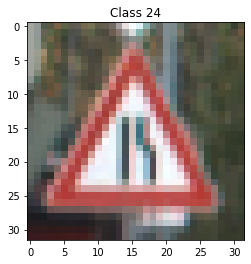

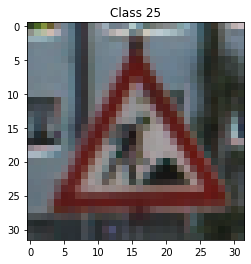

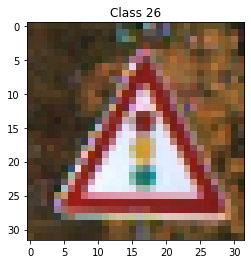

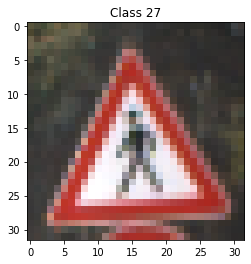

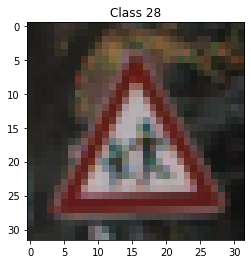

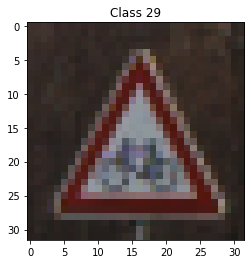

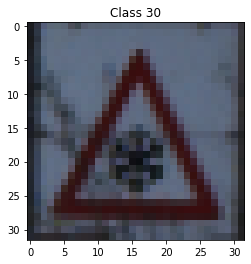

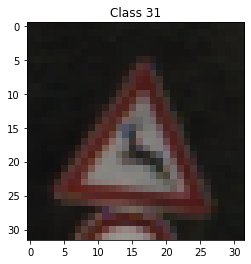

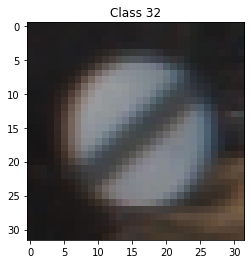

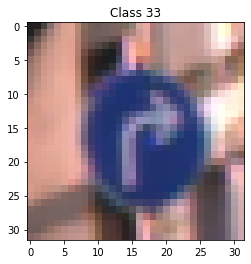

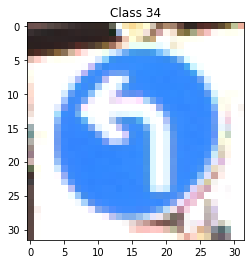

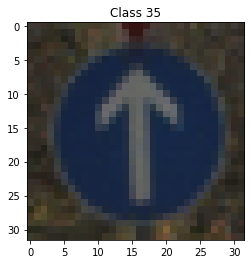

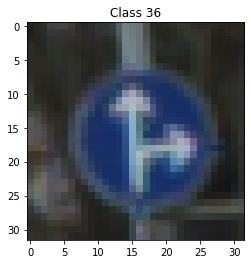

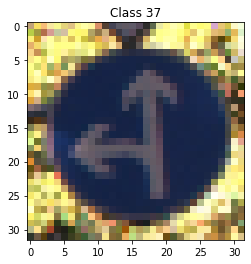

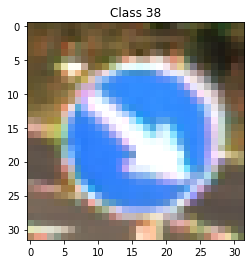

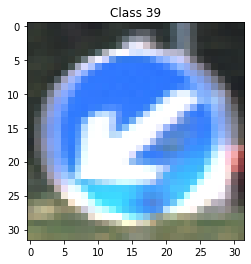

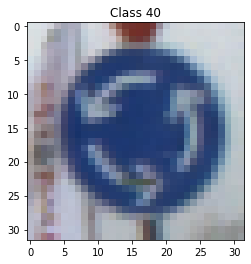

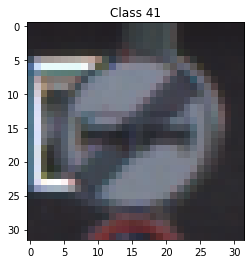

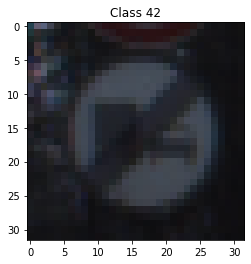

In [8]:
# plot one RGB image per class
clear_image_indices = [200, 2000, 4400, 5600, 8000, 9500, 10340, 11600, 13100, 14400, 16400, 17000,
                        19100, 20300, 23000, 23500, 23710, 24530, 26300, 26450, 26780, 27200, 27500,
                        28010, 28270, 29000, 30015, 30650, 31004, 31520, 31700, 32500, 32900, 33600,
                        33800, 35000, 35700, 35960, 36700, 38300, 38600, 38780, 39020]

plot_images(X_train, y_train, clear_image_indices)

In [9]:
# convert RGB images to grayscale
def grayscale(rgb_images):
    res = np.zeros(shape=(len(rgb_images), 
                          rgb_images.shape[1],
                          rgb_images.shape[2]))
    for i in range(len(rgb_images)):
        res[i] = cv2.cvtColor(rgb_images[i], cv2.COLOR_RGB2GRAY)
    return res

# scale image features to 0 mean and unit variance
def normalize(images):
    return (images - 128) / 128

In [10]:
# grayscale and normalize images

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

X_train_gray = normalize(X_train_gray)
X_test_gray = normalize(X_test_gray)

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


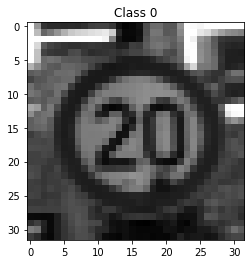

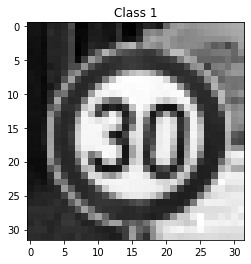

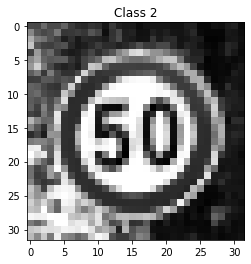

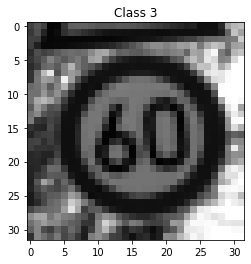

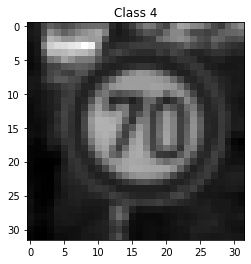

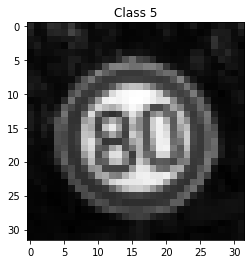

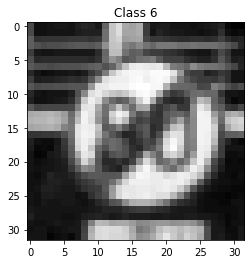

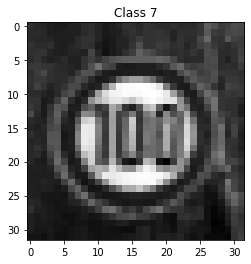

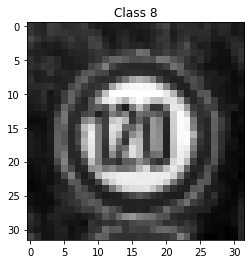

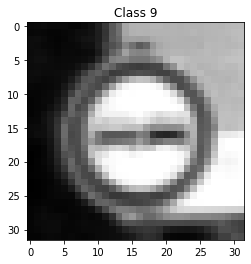

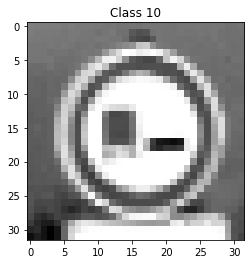

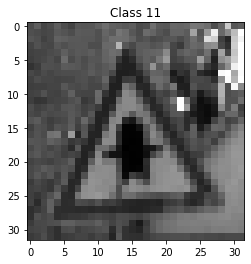

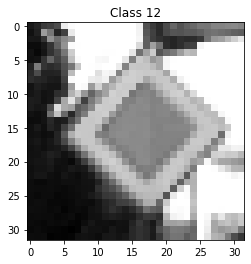

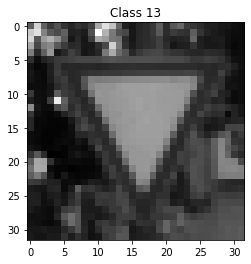

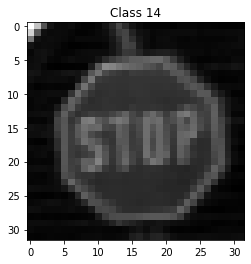

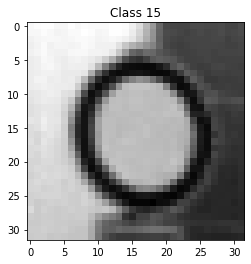

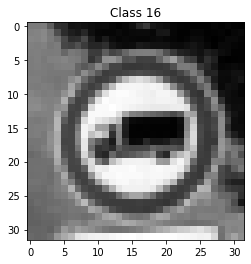

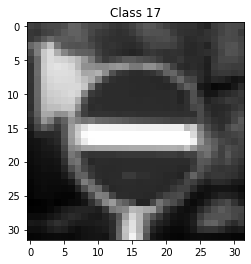

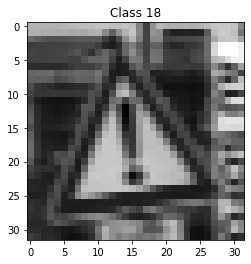

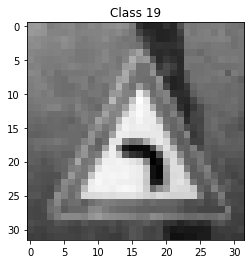

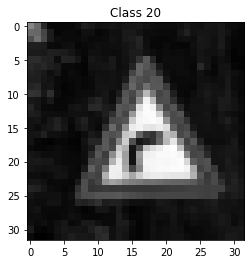

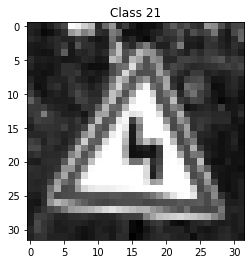

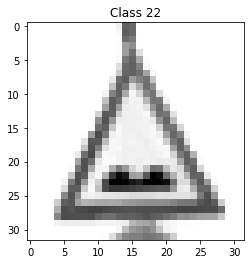

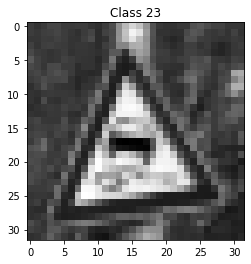

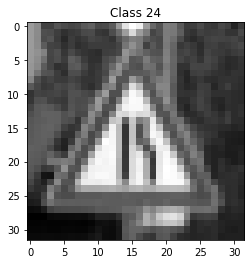

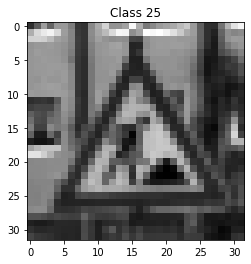

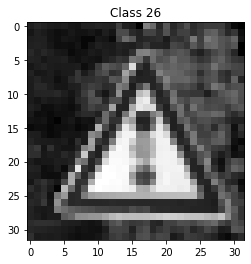

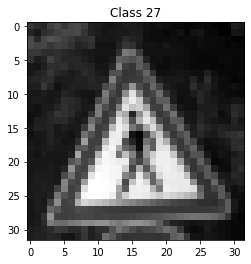

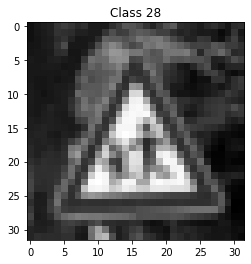

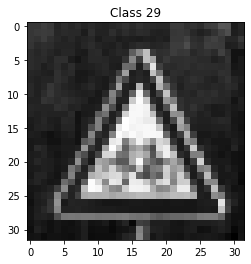

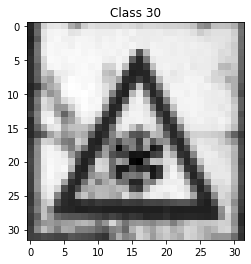

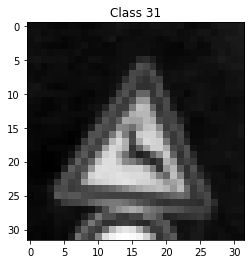

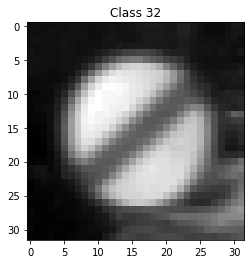

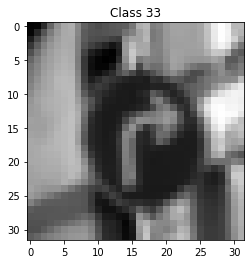

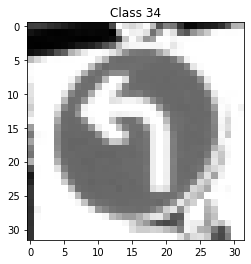

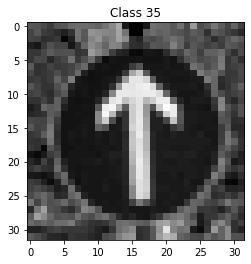

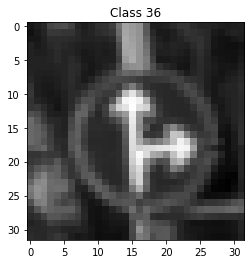

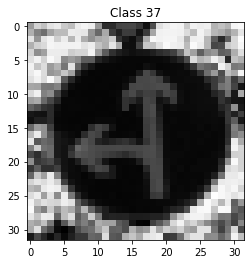

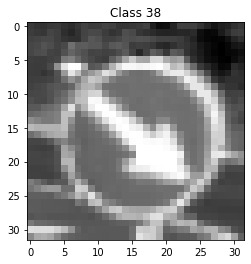

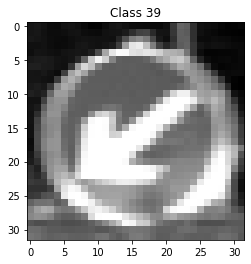

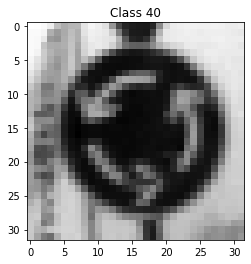

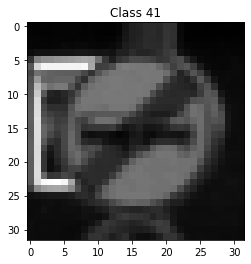

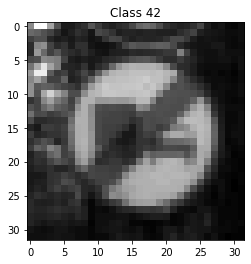

In [11]:
# plot one grayscale image per class
plot_images(X_train_gray, y_train, clear_image_indices, grayscale=True)

In [12]:
# flip these vertically
horizontal_symmetric_classes = set([12, 15, 17])

# flip these horizontally
vertical_symmetric_classes = set([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])

# class [key] flipped horizontally is class [value]
mirror_classes = {19: 20, 20: 19, 33: 34, 34: 33, 36: 37, 37: 36, 38: 39, 39: 38}

In [13]:
def synthesize_images(X, y, classes, symmetry='horizontal', example_index=0):
    s = []
    for i in range(len(X)):
        if y[i] in classes:
            s.append(i)

    shape = list(X.shape)
    shape[0] = len(s)
    X_train_syn = np.zeros(shape=shape)
    y_train_syn = np.zeros(shape=shape[0])

    example_i = example_j = -1

    for j, i in enumerate(s):
        if example_j == -1 and i == example_index:
            example_i = i
            example_j = j
        if symmetry == 'horizontal':
            X_train_syn[j] = np.flipud(X[i])
        elif symmetry == 'vertical' or symmetry == 'mirror':
            X_train_syn[j] = np.fliplr(X[i])
        if symmetry == 'mirror':
            y_train_syn[j] = classes[y[i]]
        else:
            y_train_syn[j] = y[i]
    
    print ('Example indices: {}, {}'.format(example_i, example_j))
    print ('')
    return X_train_syn, y_train_syn

In [14]:
X_train_syn, y_train_syn = synthesize_images(X_train_gray, 
                                             y_train, 
                                             horizontal_symmetric_classes, 
                                             symmetry='horizontal',
                                             example_index=19100)


print ("Number of synthesized examples: {}".format(len(X_train_syn)))

# add synthesized images to training set
X_train_gray = np.concatenate((X_train_gray, X_train_syn))
y_train = np.concatenate((y_train, y_train_syn))

Example indices: 19100, 1100

Number of synthesized examples: 3840


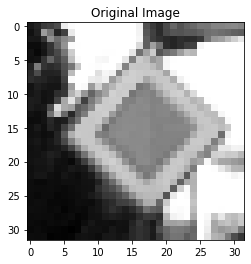

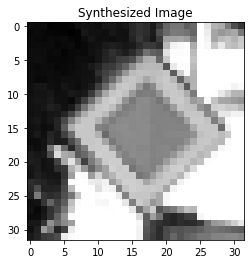

In [15]:
# plot example
plot_images(X_train_gray, y_train, [19100], grayscale=True, title='Original Image')
plot_images(X_train_syn, y_train, [1100], grayscale=True, title='Synthesized Image')

In [16]:
# synthesize vertically symmetric images
X_train_syn, y_train_syn = synthesize_images(X_train_gray, 
                                             y_train, 
                                             vertical_symmetric_classes, 
                                             symmetry='vertical',
                                             example_index=19100)

print ("Number of synthesized examples: {}".format(len(X_train_syn)))

# add synthesized images to training set
X_train_gray = np.concatenate((X_train_gray, X_train_syn))
y_train = np.concatenate((y_train, y_train_syn))


Example indices: 19100, 2420

Number of synthesized examples: 15000


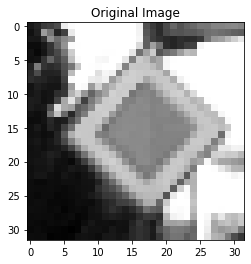

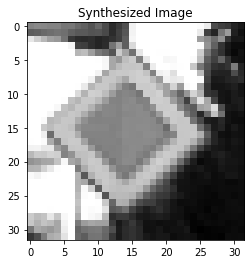

In [17]:
# plot example
plot_images(X_train_gray, y_train, [19100], grayscale=True, title='Original Image')
plot_images(X_train_syn, y_train, [2420], grayscale=True, title='Synthesized Image')


In [18]:
# synthesize mirror images
X_train_syn, y_train_syn = synthesize_images(X_train_gray, 
                                             y_train, 
                                             mirror_classes, 
                                             symmetry='mirror',
                                             example_index=35960)

print ("Number of synthesized examples: {}".format(len(X_train_syn)))

# add synthesized images to training set
X_train_gray = np.concatenate((X_train_gray, X_train_syn))
y_train = np.concatenate((y_train, y_train_syn)).astype(np.uint8)

Example indices: 35960, 2240

Number of synthesized examples: 4649


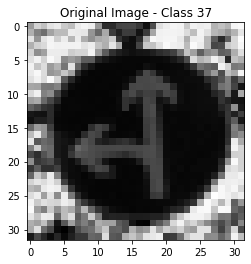

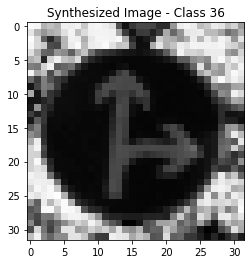

In [19]:
# plot example
plot_images(X_train_gray, y_train, [35960], grayscale=True, title='Original Image - Class 37')
plot_images(X_train_syn, y_train, [2240], grayscale=True, title='Synthesized Image - Class 36')

In [20]:
print ('Total number of synthesized training examples: {}'.format(len(X_train_gray) - len(X_train)))
print ('Total number of training examples: {}'.format(len(X_train_gray)))


Total number of synthesized training examples: 23489
Total number of training examples: 62698


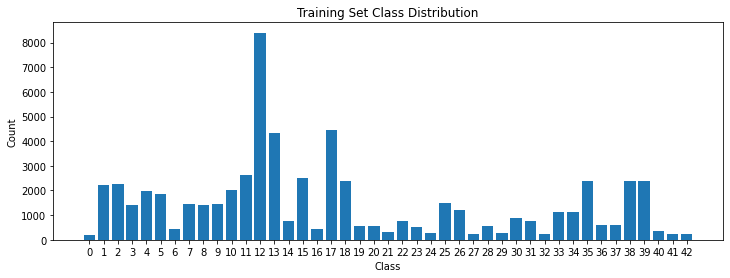

In [21]:
# display new training set class distribution
class_distribution(y_train, 'Training Set Class Distribution')

In [22]:
# Flatten data to shape [n_samples, n_features] for support vector classifier

def flatten_(data):
    if len(data.shape) <= 2:
        return data
    d = 1
    for i in range(1, len(data.shape)):
        d *= data.shape[i]
    data_flat = data.reshape(data.shape[0], d)
    return data_flat

In [23]:
X_train_svm = flatten_(X_train_gray)
y_train_svm = np.copy(y_train)
X_test_svm = flatten_(X_test_gray)

In [24]:
# shuffle the training set
X_train_svm, y_train_svm = shuffle(X_train_svm, y_train_svm, random_state=1)

In [25]:
# split training set into new training set and validation set
X_train_svm_new, X_cv_svm, y_train_svm_new, y_cv_svm = train_test_split(X_train_svm, 
                                                                        y_train_svm, 
                                                                        test_size=0.24, 
                                                                        random_state=2)

In [27]:
# train SVC on new training set
svc = SVC(C=100,random_state=5)
svc.fit(X_train_svm_new, y_train_svm_new)

SVC(C=100, random_state=5)

In [28]:
# test SVC on validation set
y_pred = svc.predict(X_cv_svm)

In [29]:
# print accuracy score
score = accuracy_score(y_pred, y_cv_svm)
print (score)

0.9702950558213717


In [30]:
svc = SVC(C=100,random_state=5)
svc.fit(X_train_svm, y_train_svm)

SVC(C=100, random_state=5)

In [31]:
# test SVM
y_pred = svc.predict(X_test_svm)

In [32]:
# print accuracy score on test set
score = accuracy_score(y_pred, y_test)
print (score)

0.7544734758511481


In [37]:
# save the model to disk
import pickle
with open('SVM_model','wb') as f:
    pickle.dump(svc,f)

In [29]:
# tune parameters by training and testing 9 SVMs on validation set, each with different C and gamma parameters
C_grid = [1, 10, 100]
g_grid = ['auto', .01, .1]

best_C = 1
best_g = 'auto'
best_score = score

for C in C_grid:
    for g in g_grid:
        if C == 1 and g == 'auto':
            continue
        svc = SVC(C=C, gamma=g, random_state=4)
        svc.fit(X_train_svm_new, y_train_svm_new)
        y_pred = svc.predict(X_cv_svm)
        score = accuracy_score(y_pred, y_cv_svm)
        print ('C: {}'.format(C))
        print ('gamma: {}'.format(g))
        print ('accuracy score: {}'.format(score))
        print ('')
        if score > best_score:
            best_C = C
            best_g = g
            best_score = score

print ("Best C: {}".format(best_C))
print ("Best gamma: {}".format(best_g))
print ("Best accuracy score: {}".format(best_score))

C: 1
gamma: 0.01
accuracy score: 0.9060340244550771

C: 1
gamma: 0.1
accuracy score: 0.5164141414141414

C: 10
gamma: auto
accuracy score: 0.9289606592238171

C: 10
gamma: 0.01
accuracy score: 0.9551435406698564

C: 10
gamma: 0.1
accuracy score: 0.5524986709197236

C: 100
gamma: auto
accuracy score: 0.9630515683147262

C: 100
gamma: 0.01
accuracy score: 0.9587985114300904

C: 100
gamma: 0.1
accuracy score: 0.552565124933546

Best C: 100
Best gamma: auto
Best accuracy score: 0.9630515683147262


In [30]:
# train SVM with best parameters on entire training set
svc = SVC(C=100, gamma=1, random_state=5)
X_train_svm, y_train_svm = shuffle(X_train_svm, y_train_svm, random_state=6)
svc.fit(X_train_svm, y_train_svm)

SVC(C=100, gamma=1, random_state=5)

In [32]:
# test SVM
y_pred = svc.predict(X_test_svm)

In [1]:
# print accuracy score on test set
score = accuracy_score(y_pred, y_test)
print (score)

NameError: name 'accuracy_score' is not defined

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.30      0.38        60
           1       0.80      0.89      0.84       720
           2       0.81      0.87      0.84       750
           3       0.72      0.81      0.76       450
           4       0.85      0.78      0.81       660
           5       0.77      0.83      0.80       630
           6       0.77      0.67      0.72       150
           7       0.89      0.75      0.82       450
           8       0.80      0.84      0.82       450
           9       0.90      0.78      0.84       480
          10       0.90      0.94      0.92       660
          11       0.68      0.87      0.76       420
          12       0.64      0.93      0.76       690
          13       0.96      0.96      0.96       720
          14       0.89      0.81      0.85       270
          15       0.60      0.77      0.67       210
          16       0.99      0.97      0.98       150
          17       0.84    

In [ ]:
#####Convolution neural network

In [48]:
X_train_gray, y_train = shuffle(X_train_gray, y_train, random_state=1)

In [49]:
# split training set into new training set and validation set
X_train_nn, X_cv_nn, y_train_nn, y_cv_nn = train_test_split(X_train_gray, 
                                                            y_train, 
                                                            test_size=0.24, 
                                                            random_state=2)


In [86]:
### LeNet-5 architecture
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
##from tensorflow.contrib.layers import flatten

def LeNet(x, mu=0, sigma=0.1):
    x = tf.reshape(x, (-1, 32, 32, 1))

    # Convolution Layer 1. Input = 32x32x1. Output = 28x28x6.
    # (height, width, input_depth, output_depth)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation 1.
    conv1 = tf.nn.relu(conv1)

    # Pooling Layer 1. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolution Layer 2. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling Layer 2. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten Layer.
    fc1 = flatten(conv2)
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)

    # Fully Connected Layer 1. Input = 5x5x16. Output = 120.
    fc1_W     = tf.Variable(tf.truncated_normal(shape=(fc1_shape), mean=mu, stddev=sigma))
    fc1_b     = tf.Variable(tf.zeros(120))
    fc1       = tf.matmul(fc1, fc1_W) + fc1_b

    # Activation 3.
    fc1 = tf.nn.relu(fc1)

    # Fully Connected Layer 2. Input = 120. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean=mu, stddev=sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc2_W) + fc2_b

    return logits

In [83]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# x = tf.placeholder(tf.float32, (None, 32, 32, 3))
x = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [85]:
# define learning rate, logits, loss, optimizer

learning_rate = 0.001
logits = LeNet(x)
softmax = tf.nn.softmax(logits)
loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

NameError: name 'flatten' is not defined